# **Dataset tutorial: A large and rich EEG dataset for modeling human visual object recognition**

In this tutorial you will load, visualize and model the preprocessed EEG data, the corresponding image conditions and the deep neural network (DNN) feature maps of these image conditions from the data paper [A large and rich EEG dataset for modeling human visual object recognition][paper_link]. This dataset contains the EEG responses of 10 participants to 16,540 training image conditions (with 4 repeats per condition) and 200 test image conditions (with 80 repeats per condition).

The largness of this dataset enables the modeling of EEG data through several machine learning and deep learning methods, including building end-to-end encoding models of EEG responses to arbitrary images starting from randomly initialized DNNs.

The complete dataset (in its raw and preprocessed format) along with the stimuli images, DNN feature maps and detailed data descriptions are available on [OSF][osf]. Please refer to the [paper][paper_link] for information regarding stimuli images, experimental paradigm, EEG acquisition/preprocessing, DNN feature maps extraction and dataset validation through several computational modeling approaches. All the paper results can be reproduces through the code available on [GitHub][git]. You can find additional useful information on the [dataset website][website].

[paper_link]: https://www.biorxiv.org/content/10.1101/2022.03.15.484473v1
[osf]: https://osf.io/3jk45/
[git]: https://github.com/gifale95/eeg_encoding
[website]: https://www.alegifford.com/publications/eeg_dataset/

## 1. Import libraries and mount Google Drive to access the data

The data used in this tutorial is found in a Google Drive public folder called [```tutorial_data```][data]. Before running the tutorial code you need to select this folder and choose "Add a shortcut to Drive". This will create a shortcut (without copying or taking space) of the folder to a desired path in your Google Drive, from which you can read the content after mounting using ```drive.mount()```.

Next, you will import the Python libraries used throughout the tutorial and mount your Google Drive to access the data. Make sure that you edit the ```gdrive_data_parent_dir``` variable with the path to the ```tutorial_data``` shortcut folder you added to your Drive.

[data]: https://drive.google.com/drive/folders/1ZejP4F9Isj2A_QSlxbPzvOP16-BdBerk?usp=sharing

In [6]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr as corr
import os

## 2. Load the preprocessed EEG data

Now you will load participant's 1 preprocessed EEG data. The EEG data consists of two files:
* ```preprocessed_eeg_training.npy```: the preprocessed EEG training data.
* ```preprocessed_eeg_test.npy```: the preprocessed EEG test data.

Both files are Python dictionaries with the following keys:
* ```preprocessed_eeg_data```: preprocessed EEG data in a 4-dimensional array of shape [16,540/200 train/test image conditions × 4/80 train/test EEG repetitions × 17 EEG channels × 100 EEG time points].
* ```ch_names```: names of the 17 occipital and parietal EEG channels retained during preprocessing.
* ```times```: the 100 time points of each EEG epoch (in seconds, with respect to stimulus onset).

In [3]:
eeg_data_train = np.load("..\data\sub-01\preprocessed_eeg_training.npy", allow_pickle=True).item()
eeg_data_test = np.load("..\data\sub-01\preprocessed_eeg_test.npy", allow_pickle=True).item()

print('Training EEG data shape:')
print(eeg_data_train['preprocessed_eeg_data'].shape)
print('(Training image conditions × Training EEG repetitions × EEG channels × '
    'EEG time points)')

print('\nTest EEG data shape:')
print(eeg_data_test['preprocessed_eeg_data'].shape)
print('(Test image conditions × Test EEG repetitions × EEG channels × '
    'EEG time points)')

print('\nEEG channels:')
for c,chan in enumerate(eeg_data_train['ch_names']):
    print(c, chan)

print('\nEEG time points (in seconds):')
for t,time in enumerate(eeg_data_train['times']):
    print(t, np.round(time, decimals=2))

Training EEG data shape:
(16540, 4, 17, 100)
(Training image conditions × Training EEG repetitions × EEG channels × EEG time points)

Test EEG data shape:
(200, 80, 17, 100)
(Test image conditions × Test EEG repetitions × EEG channels × EEG time points)

EEG channels:
0 Pz
1 P3
2 P7
3 O1
4 Oz
5 O2
6 P4
7 P8
8 P1
9 P5
10 PO7
11 PO3
12 POz
13 PO4
14 PO8
15 P6
16 P2

EEG time points (in seconds):
0 -0.2
1 -0.19
2 -0.18
3 -0.17
4 -0.16
5 -0.15
6 -0.14
7 -0.13
8 -0.12
9 -0.11
10 -0.1
11 -0.09
12 -0.08
13 -0.07
14 -0.06
15 -0.05
16 -0.04
17 -0.03
18 -0.02
19 -0.01
20 0.0
21 0.01
22 0.02
23 0.03
24 0.04
25 0.05
26 0.06
27 0.07
28 0.08
29 0.09
30 0.1
31 0.11
32 0.12
33 0.13
34 0.14
35 0.15
36 0.16
37 0.17
38 0.18
39 0.19
40 0.2
41 0.21
42 0.22
43 0.23
44 0.24
45 0.25
46 0.26
47 0.27
48 0.28
49 0.29
50 0.3
51 0.31
52 0.32
53 0.33
54 0.34
55 0.35
56 0.36
57 0.37
58 0.38
59 0.39
60 0.4
61 0.41
62 0.42
63 0.43
64 0.44
65 0.45
66 0.46
67 0.47
68 0.48
69 0.49
70 0.5
71 0.51
72 0.52
73 0.53
74 0.54
7

## 3. Visualize the preprocessed EEG data ERPs

Here you will plot the preprocessed EEG data event related potentials (ERPs) across time, for each EEG channel. ERPs consist in the EEG signal averaged across image conditions and repetitions.

The ERPs show peaks of activity every 200ms, consistent with the 200ms stimulus onset asynchronies (SOAs) of the rapid serial visual presentation (RSVP) paradigm used to collect the EEG data.

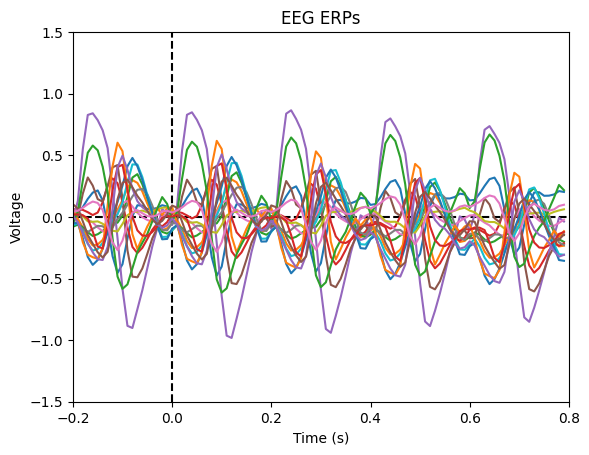

In [4]:
erp_data_train = np.mean(eeg_data_train['preprocessed_eeg_data'], 1)
erp_data_test = np.mean(eeg_data_test['preprocessed_eeg_data'], 1)
erp_data_all = np.mean(np.append(erp_data_train, erp_data_test, 0), 0)

plt.figure()
plt.plot([-.2, .8], [0, 0], 'k--', [0, 0], [-1.5, 1.5], 'k--')
plt.plot(eeg_data_train['times'], np.transpose(erp_data_all));
plt.xlabel('Time (s)');
plt.xlim(left=-.2, right=.8)
plt.ylabel('Voltage');
plt.ylim(bottom=-1.5, top=1.5)
plt.title('EEG ERPs');

## 4. Load the images metadata

Next, you will load and visualize the metadata of the EEG responses' stimuli images. The images are divided into a training and a test partition (corresponding to the EEG training and test data partitions). The training partition has 1,654 object concepts, with 10 images per concept, for a total of 16,540 image conditions. The test partition has 200 object concepts with 1 image per concept, for a total of 200 image conditions.

In [5]:
img_metadata = np.load("..\data\image_metadata.npy", allow_pickle=True).item()

n_train_img = len(img_metadata['train_img_concepts'])
n_train_concepts = len(np.unique(img_metadata['train_img_concepts']))
n_train_img_per_concept = int(n_train_img / n_train_concepts)
print('Training images: ' + str(n_train_img))
print('Image concepts: ' + str(n_train_concepts))
print('Images per concept: '+ str(n_train_img_per_concept))

n_test_img = len(img_metadata['test_img_concepts'])
n_test_concepts = len(np.unique(img_metadata['test_img_concepts']))
n_test_img_per_concept = int(n_test_img / n_test_concepts)
print('\nTest images: ' + str(n_test_img))
print('Image concepts: ' + str(n_test_concepts))
print('Images per concept: '+ str(n_test_img_per_concept))

Training images: 16540
Image concepts: 1654
Images per concept: 10

Test images: 200
Image concepts: 200
Images per concept: 1


## 5. Visualize the training images, and link them to the corresponding EEG responses

Here you can visualize arbitrary images from the **training** partition, and link them to their corresponding EEG responses. Select the image of interest by editing the ```train_img_idx``` variable with values in the range [0 16,539] (Python indexing stars from 0).

Training EEG single image data shape:
(4, 17, 100)
(Training EEG repetitions × EEG channels × EEG time points)



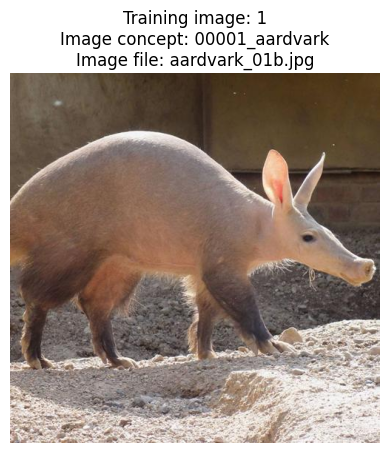

In [8]:
train_img_idx =  0 #@param {type:"integer"}

eeg_data_single_image = eeg_data_train['preprocessed_eeg_data'][train_img_idx]
print('Training EEG single image data shape:')
print(eeg_data_single_image.shape)
print('(Training EEG repetitions × EEG channels × EEG time points)\n')

train_img_dir = os.path.join('..\data\\training_images',
	img_metadata['train_img_concepts'][train_img_idx],
	img_metadata['train_img_files'][train_img_idx])
train_img = Image.open(train_img_dir).convert('RGB')

plt.figure()
plt.axis('off')
plt.imshow(train_img)
plt.title('Training image: ' + str(train_img_idx+1) + '\nImage concept: ' +\
	img_metadata['train_img_concepts'][train_img_idx] + '\nImage file: ' +\
	img_metadata['train_img_files'][train_img_idx]);

## 6. Visualize the test images, and link them to the corresponding EEG responses

Here you can visualize arbitrary images from the test partition, and link them to their corresponding EEG responses. Select the image of interest by editing the ```test_img_idx``` variable with values in the range [0 199] (Python indexing stars from 0).

Test EEG single image data shape:
(80, 17, 100)
(Test EEG repetitions × EEG channels × EEG time points)



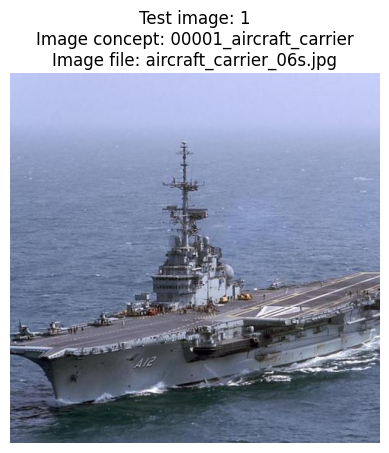

In [10]:
test_img_idx =  0 #@param {type:"integer"}

eeg_data_single_image = eeg_data_test['preprocessed_eeg_data'][train_img_idx]
print('Test EEG single image data shape:')
print(eeg_data_single_image.shape)
print('(Test EEG repetitions × EEG channels × EEG time points)\n')

test_img_dir = os.path.join('..\data\\test_images',
	img_metadata['test_img_concepts'][test_img_idx],
	img_metadata['test_img_files'][test_img_idx])
test_img = Image.open(test_img_dir).convert('RGB')

plt.figure()
plt.axis('off')
plt.imshow(test_img)
plt.title('Test image: ' + str(test_img_idx+1) + '\nImage concept: ' +\
	img_metadata['test_img_concepts'][test_img_idx] + '\nImage file: ' +\
	img_metadata['test_img_files'][test_img_idx]);

## 7. Load the DNN feature maps

Now you will load the training an test images feature maps of a pretrained AlexNet architecture, that have been appended across all DNN layers and downsampled with principal component analysis (PCA). The DNN feature consists of two files:
* ```pca_feature_maps_training.npy```: the training DNN feature maps.
* ```pca_feature_maps_test.npy```: the test DNN feature maps.

Both files are Python dictionaries with the following key:
* ```all_layers```: DNN feature maps in a 2-dimensional array of shape [16,540/200 train/test image conditions × 3000 DNN feature maps PCA components].

In [ ]:
dnn_parent_dir = os.path.join(gdrive_data_parent_dir, 'dnn_feature_maps',
    'pca_feature_maps', 'alexnet', 'pretrained-True', 'layers-all')
dnn_fmaps_train = np.load(os.path.join(dnn_parent_dir,
    'pca_feature_maps_training.npy'), allow_pickle=True).item()
dnn_fmaps_test = np.load(os.path.join(dnn_parent_dir,
    'pca_feature_maps_test.npy'), allow_pickle=True).item()

print('Training DNN feature maps shape:')
print(dnn_fmaps_train['all_layers'].shape)
print('(Training image conditions × DNN feature maps PCA components)')

print('\nTraining DNN feature maps shape:')
print(dnn_fmaps_test['all_layers'].shape)
print('(Test image conditions × DNN feature maps PCA components)')

Training DNN feature maps shape:
(16540, 3000)
(Training image conditions × DNN feature maps PCA components)

Training DNN feature maps shape:
(200, 3000)
(Test image conditions × DNN feature maps PCA components)


## 8. Train and test linearizing encoding models of EEG visual responses

In this last step you will train linearizing encoding models of EEG visual responses, that is, algorithms that predict the EEG responses to arbitrary stimuli images. Linearizing encoding models consist of linear regressions that map the DNN feature maps of certain image conditions onto the corresponding EEG responses. You will train independent linear regressions for each EEG feature (i.e., each combination of EEG channels and time points).

You will train linear regressions using the training DNN feature maps and training EEG data (averaged across repetitions), and use the learned regression weights to predict the EEG responses to the test images (using the test DNN feature maps). To reduce computational load, the training/test DNN feature maps are reduced to 100 PCA components.

Finally, you will quantify the encoding models prediction accuracy by correlating each predicted EEG feature with the corresponding biological/ground truth EEG feature (averaged across repetitions) across the 200 test image conditions, average the resulting correlation scores over channels, and plot them across time points.

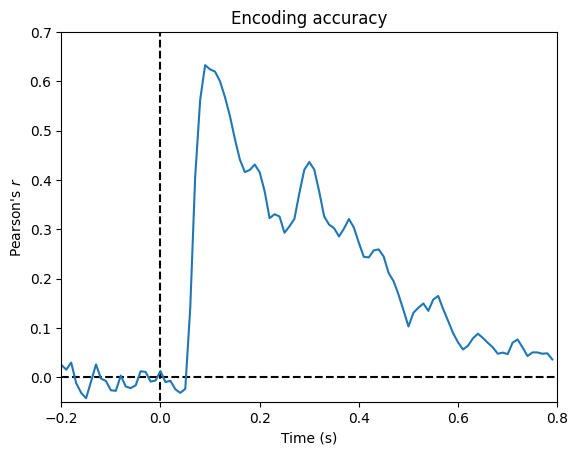

In [ ]:
# Train the encoding models
eeg_data_train_avg = np.mean(eeg_data_train['preprocessed_eeg_data'], 1)
eeg_data_train_avg = np.reshape(eeg_data_train_avg,
    (eeg_data_train_avg.shape[0], -1))
reg = LinearRegression().fit(dnn_fmaps_train['all_layers'][:,:100],
    eeg_data_train_avg)
pred_eeg_data_test = reg.predict(dnn_fmaps_test['all_layers'][:,:100])
pred_eeg_data_test = np.reshape(pred_eeg_data_test,
    (-1, len(eeg_data_train['ch_names']), len(eeg_data_train['times'])))

# Test the encoding models
eeg_data_test_avg = np.mean(eeg_data_test['preprocessed_eeg_data'], 1)
encoding_accuracy = np.zeros((len(eeg_data_test['ch_names']),
    len(eeg_data_test['times'])))
for t in range(len(eeg_data_test['times'])):
    for c in range(len(eeg_data_test['ch_names'])):
        encoding_accuracy[c,t] = corr(pred_eeg_data_test[:,c,t],
            eeg_data_test_avg[:,c,t])[0]

# Plot the results
plt.figure()
plt.plot([-.2, .8], [0, 0], 'k--', [0, 0], [-1, 1], 'k--')
plt.plot(eeg_data_test['times'], np.mean(encoding_accuracy, 0));
plt.xlabel('Time (s)');
plt.xlim(left=-.2, right=.8)
plt.ylabel('Pearson\'s $r$');
plt.ylim(bottom=-.05, top=.7)
plt.title('Encoding accuracy');